In [32]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")


from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

display(HTML("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>"""))

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

<div class="custom-assignment-text">

# Part 1: Similarity Metrics

</div>

In [2]:
from cs168.mini_project_2 import load_data
from itertools import combinations
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_approx_equal, assert_allclose
import pandas as pd
from scipy.spatial.distance import pdist, squareform

# 7 is the precision checked by the approximate equality test methods by default
pd.set_option("precision", 7)

from bokeh.io import output_file, show, output_notebook, output_file, reset_output
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter, HoverTool, Title)
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh import palettes

<div class="custom-assignment-text">

## Goal 

The goal of this part of the assignment is to understand better the differences between distance
metrics, and to think about which metric makes the most sense for a particular application.

</div>

<div class="custom-assignment-text">

## Description

In this part you will look at the similarity between the posts on various newsgroups. We’ll use the well-known [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/). You will use a version of the dataset where every article is represented by a bag-of-words — a vector indexed by words, with each component indicating the number of occurrences of that word. You will need 3 files: `data50.csv`, `label.csv`, and `group.csv`, all of these can be downloaded from the course website. In `data50.csv` there is a sparse representation of the bags-of-words, with each line containing 3 fields: `articleId`, `wordId`, and `count`. To find out which group an article belongs to, use the file `label.csv`, where for `articleId` $i$, line $i$ in `label.csv` contains the `groupId`. Finally the group name is in `group.csv`, with line $i$ containing the name of group $i$.

We’ll use the following similarity metrics, where $x$ and $y$ are two bags of words:

* Jaccard Similarity: $J(x,y) = \frac{\sum_i{min(x_i,y_i)}}{\sum_i{max(x_i,y_i)}}$
* $L_2$ Similarity: $L_2(x,y) = \|x - y\|_2 = -\sqrt{\sum_i(x_i - y_i)^2}$
* Cosine Similarity: $S_C(x, y) = \frac{\sum_i{x_i \cdot y_i}}{\|x\|_2 \cdot \|y\|_2}$

Note that Jaccard and cosine similarity are numbers between 0 and 1, while $L_2$ similarity is between $-\infty$ and 0 (with higher numbers indicating more similarity).

</div>

<div class="custom-assignment-text">

(a) (2 points) Make sure you can import the given datasets into whatever language you’re using. For
example, if you’re using python, read the data50.csv file and store the information in an appropriate
way. Remember that the total number of words in the corpus is huge, so you might want to work with
a sparse representation of your data (e.g., you don’t want to waste space on words that don’t occur in
a document). If you’re using MATLAB, you can simply import the data using the GUI.

</div>

In [3]:
GROUP_NAMES, DATA, LABELS = load_data()

assert GROUP_NAMES.shape == (20,)
assert GROUP_NAMES.isnull().sum().sum() == 0
assert GROUP_NAMES.index[0] == 1

assert DATA.shape == (1000, 19575)
assert DATA.isnull().sum().sum() == 0
assert DATA.index[0] == 1

assert LABELS.shape == (1000,)
assert LABELS.isnull().sum().sum() == 0
assert LABELS.index[0] == 1

ok()

<div class="custom-assignment-text">

(b) (8 points) Implement the three similarity metrics described above. For each metric, prepare the following plot. The plot will look like a 20 × 20 matrix. Rows and columns are index by newsgroups (in the same order). For each entry $(A, B)$ of the matrix (including the diagonal), compute the average similarity over all ways of pairing up one article from $A$ with one article from $B$. After you’ve computed these 400 numbers, plot your results in a heatmap. Make sure that you label your axes with the group
names and pick an appropriate colormap to represent the data: the rainbow colormap may look fancy, but a simple color map from white to blue may be a lot more insightful. Make sure to include a legend. (Note that the computation might take five or ten minutes, but shouldn’t take much more.)

</div>

In [4]:
# Ultra-simple rows for testing the similarity metrics below
def get_test_rows():
    return (pd.DataFrame([4, 5, 6]), pd.DataFrame([5, 4, 6]), pd.DataFrame([1, 2, 6]), pd.DataFrame([0, 0, 0]))

In [5]:
def jaccard_sim(x, y):
    divisor = np.maximum(x,y).sum().item()
    if divisor == 0:
        return 1.0
    df = np.minimum(x, y).sum() / divisor
    return df.item()

def _test_jaccard_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert jaccard_sim(df_1, df_2) == 14/16 == .875
    assert jaccard_sim(df_1, df_3) == 9/15 == .6
    assert jaccard_sim(df_1, df_1) == 1
    assert jaccard_sim(df_0, df_0) == 1

_test_jaccard_sim()
ok()

In [6]:
def l2_norm(x):
    return math.sqrt((x**2).sum())

def l2_sim(x, y):
    return -l2_norm(x - y)

def _test_l2_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert_approx_equal(l2_sim(df_1, df_2), -1.4142136)
    assert_approx_equal(l2_sim(df_1, df_3), -4.2426407)
    assert_approx_equal(l2_sim(df_2, df_3), -4.472136)
    assert_approx_equal(l2_sim(df_1, df_1), 0)
    assert_approx_equal(l2_sim(df_0, df_0), 0)

_test_l2_sim()
ok()

In [7]:
def cosine_sim(x, y):
    divisor = (l2_norm(x) * l2_norm(y))
    if divisor == 0:
        return 1
    df = (x*y).sum() / divisor
    return df.item()

def _test_cosine_sim():
    (df_1, df_2, df_3, df_0) = get_test_rows()
    assert_approx_equal(cosine_sim(df_1, df_2), 0.987013)
    assert_approx_equal(cosine_sim(df_1, df_3), 0.8898826)
    assert_approx_equal(cosine_sim(df_1, df_1), 1)
    assert_approx_equal(cosine_sim(df_0, df_0), 1)

_test_cosine_sim()
ok()

Note that using the distance functions provided in `scipy.spatial.distance` would likely be more performant, but to fulfill the requirements of the assignment we've re-implemented them above.

In [8]:
def get_all_similarities(df, metric, include_diagonal=True):
    """Returns a square matrix where the (i, j)th element
    is the result of calculating metric(df[i],df[j])"""

    similarities = pd.DataFrame(
        squareform(pdist(df, metric)), index=df.index, columns=df.index
    )
    # Numpy skips the diagonal
    if include_diagonal:
        for idx, row in df.iterrows():
            val = metric(row, row)
            similarities[idx][idx] = metric(row, row)
    return similarities

def _test_get_all_similarities():
    test_data = pd.DataFrame([[4, 5, 6], [5, 4, 6], [1, 2, 6]])
    actual = get_all_similarities(test_data, l2_sim)
    expected = [
            [0.0, -1.41421356, -4.24264069],
            [-1.41421356, 0.0, -4.47213595],
            [-4.24264069, -4.47213595, 0.0],
        ]
    assert_allclose(actual, expected)

_test_get_all_similarities()
ok()

In [9]:
def get_average_similarities(data, metric, labels):
    """Params:
    - data: dataframe containing rows to be compared against each other
    - metric: similarity metric for comparing rows
    - labels: labels for the rows in data
    Returns: a square symmetric matrix where elements (i, j) and (j, i) give the average
    similarity score among all pairs of data rows with label i and all with label j."""
    unique_labels = pd.unique(labels)
    all_similarities = pd.DataFrame(get_all_similarities(data, metric))
    all_label_average_similarities = []

    for idx_1, label_1 in enumerate(unique_labels):
        label_1_similarities = []
        for idx_2, label_2 in enumerate(unique_labels):
            # similarity is symmetric, so don't compute sim(j, i) if we've already computed sim(i, j)
            if idx_2 < idx_1:
                label_1_similarities.append(all_label_average_similarities[idx_2][idx_1])
                continue
            # get all similarities between items of label_1 and label_2
            filtered = all_similarities[labels == label_1].loc[:, labels == label_2]
            # then average these
            average_label_similarities = filtered.mean().mean()
            label_1_similarities.append(average_label_similarities)
        all_label_average_similarities.append(label_1_similarities)
    
    df = pd.DataFrame(all_label_average_similarities, columns=unique_labels, index=unique_labels).transpose()
    return df

def _test_get_average_similarities():
    test_data = pd.DataFrame([[4, 5, 6], [5, 4, 6], [1, 2, 6]])
    test_labels = pd.Series([1,2,1])
    expected = [
        [-2.1213203, -2.9431748], 
        [-2.9431748, 0]
    ]
    actual = get_average_similarities(test_data, l2_sim, test_labels)
    assert_allclose(actual, expected)

_test_get_average_similarities()
ok()

In [10]:
%time JACCARD_SIMILARITIES = get_average_similarities(DATA, jaccard_sim, LABELS)
JACCARD_SIMILARITIES = JACCARD_SIMILARITIES.rename(index=GROUP_NAMES, columns=GROUP_NAMES)

CPU times: user 1min, sys: 722 ms, total: 1min
Wall time: 1min 3s


In [11]:
%time L2_SIMILARITIES = get_average_similarities(DATA, l2_sim, LABELS)
L2_SIMILARITIES = L2_SIMILARITIES.rename(index=GROUP_NAMES, columns=GROUP_NAMES)

CPU times: user 26.2 s, sys: 443 ms, total: 26.6 s
Wall time: 27 s


In [12]:
%time COSINE_SIMILARITIES = get_average_similarities(DATA, cosine_sim, LABELS)
COSINE_SIMILARITIES = COSINE_SIMILARITIES.rename(index=GROUP_NAMES, columns=GROUP_NAMES)

CPU times: user 46.2 s, sys: 689 ms, total: 46.9 s
Wall time: 47.2 s


In [13]:
# Adapted from code provided by course
def matplotlib_heat_map(df, title):
    fig, ax = plt.subplots()
    # create the map w/ color bar legend
    heatmap = ax.pcolor(df, cmap=plt.cm.Blues)
    cbar = plt.colorbar(heatmap)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(df.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(df.shape[1])+0.5, minor=False)

    # diagonal matrix from top-left to bottom right
    ax.invert_yaxis()

    ax.set_xticklabels(df.index)
    ax.set_yticklabels(df.index)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    # make text smaller so it doesn't overlap
    ax.tick_params(axis='x', which='major', labelsize=8)

    ax.set_title(title)

    plt.tight_layout()


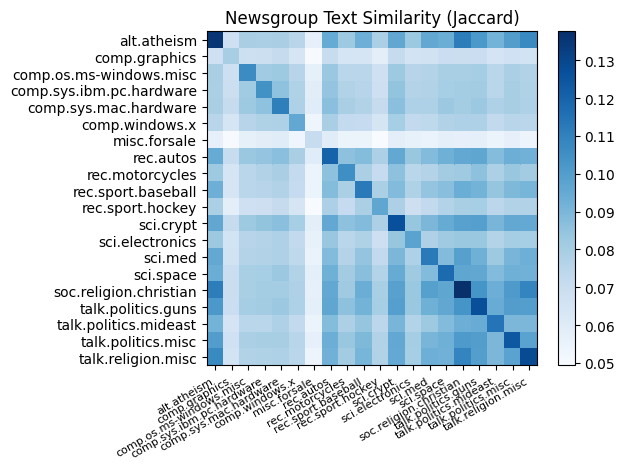

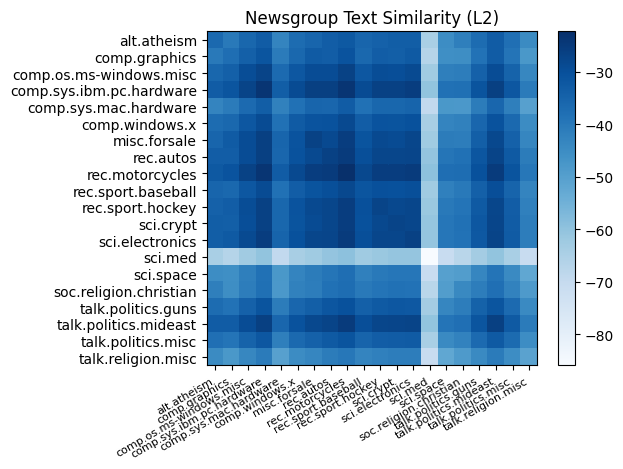

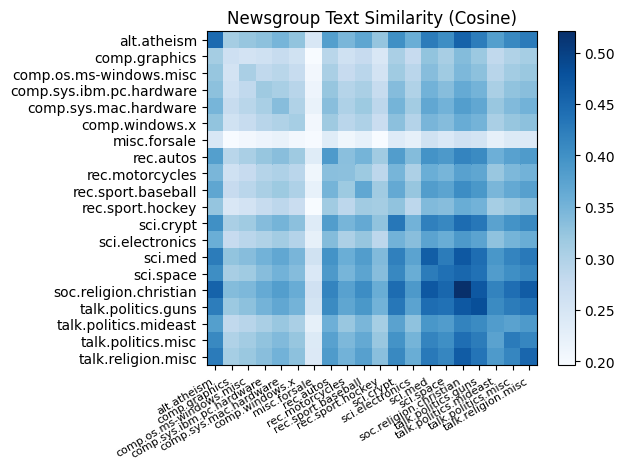

In [14]:
matplotlib_heat_map(JACCARD_SIMILARITIES, "Newsgroup Text Similarity (Jaccard)")
matplotlib_heat_map(L2_SIMILARITIES, "Newsgroup Text Similarity (L2)")
matplotlib_heat_map(COSINE_SIMILARITIES, "Newsgroup Text Similarity (Cosine)")

While I appreciate the example code provided for the course, I find the above plots very difficult to inspect; I have to trace my fingers along the rows of squares to figure out which squares are comparing which categories. The text is also grainy, though that could probably be fixed by increasing the resolution of the image.

To make the results easier to examine, I put together the version below using Bokeh instead. When the cursor is hovered over an entry in the heat map, a tooltip displays the two categories being compared, along with their similarity score.

In [15]:
def bokeh_heat_map(input_df, title, file_name=None):
    """Parameters:
    - input_db: a 2D DataFrame containing category similarity data
    - title: the title of the plot, and optionally of the generated HTML
    - file_name: if provided, HTML will be written to this file and then 
        opened in the browser automatically; if not provided, the plot will
        be shown inline in the notebook."""
    
    if len(input_df.shape) != 2:
        raise ValueError(f"Expected a 2D DataFrame; shape of input_df was {input_df.shape}")
    
    # level_X is the default identifier in a DataFrame with unnamed index/columns
    dim_0_name = input_df.index.name or "level_0"
    dim_1_name = input_df.columns.name or "level_1"
    
    # Bokeh requires a stack; x and y cateogory dimensions become columns "level_0" and "level_1"
    df = pd.DataFrame(input_df.stack(), columns=["similarity"]).reset_index()
    source = ColumnDataSource(df)

    # Show category names and the similarity score under the cursor
    hover = HoverTool(
        tooltips=[("", f"@{dim_1_name}"), ("", f"@{dim_0_name}"), ("", "@similarity")]
    )
    
    # set up figure
    fig = figure(
        title=Title(text=title, text_font_size="18pt"),
        x_range=list(input_df.index),
        y_range=list(reversed(input_df.columns)),
        toolbar_location=None, 
        tools=[hover], 
        x_axis_location="below")
    
    reset_output()
    
    if file_name:
        output_file(file_name, title=title)
        fig.sizing_mode = 'stretch_both'
    else:
        output_notebook(hide_banner=True)
        # using stretch dimensions in a notebook results in a tiny, unreadable figure
        fig.height = 600
        fig.width = 800
        
    # remove lines and ticks
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    fig.axis.axis_line_color = None
    fig.axis.major_tick_line_color = None
    fig.axis.major_label_text_font_size = "10pt"
    fig.axis.major_label_standoff = 0
    # slanted to the left
    fig.xaxis.major_label_orientation = 1.0

    # Draw rectangles for the heat map
    # values increase from light to dark blue
    colors = list(reversed(palettes.Blues8))
    mapper = LinearColorMapper(palette=colors, low=df.similarity.min(), high=df.similarity.max())
    fig.rect(x=dim_0_name, y=dim_1_name, width=1, height=1, source=source,
           line_color=None, fill_color=transform('similarity', mapper))

    # Add a color key on the right side
    color_bar = ColorBar(color_mapper=mapper,
                         ticker=BasicTicker(desired_num_ticks=len(colors)),
                         formatter=PrintfTickFormatter(format="%.3f"))
    fig.add_layout(color_bar, 'right')

    show(fig)

In [16]:
# transpose so we get lower triangular matrix, which is easier to read
bokeh_heat_map(JACCARD_SIMILARITIES.transpose(), "Newsgroup Text Similarity (Jaccard)")
bokeh_heat_map(L2_SIMILARITIES.transpose(), "Newsgroup Text Similarity (L2)")
bokeh_heat_map(COSINE_SIMILARITIES.transpose(), "Newsgroup Text Similarity (Cosine)")

<div class="custom-assignment-text">

(c) (4 points) Based on your three heatmaps, which of the similarity metrics seems the most reasonable, and why would you expect that/those metrics to be better suited to this data?

Are there any pairs of newsgroups that are very similar?

Would you have expected these to be similar?

</div>

Observations:

1. I would expect the diagonal to be darkest section of the plot for all of the plots, but the pattern is completely missing in the L2 plot and is pretty faint in the Cosine plot. The pattern is very clear in the Jaccard plot, though.
2. The `forsale` topic in the Jaccard and Cosine plots, and the `med` topic in the L2 plot have clearly visible white strips; I suppose this could be caused by a topic having quite a wide range of subtopics (medicine could be skin care or lung cancer or jogging, while forsale could be related to a wide variety of items from computers to dirt). It's surprising to me, though, that the similarity metrics disagree on which topics have this attribute. Once again, I think I trust the Jaccard metric the most, as it's the only one where a topic is clearly very different from all other topics while still being somewhat similar to itself.
3. The Cosine plot has a small cluster of related topics: Christianity, religion, atheism, guns, and maybe space. The L2 plot has a huge chunk of topics with high similarity, and while some of the topics actually are related, I think the cluster is much bigger than it should be. It's more useful to have smaller groups of related topics, as it indicates that the the score is correctly finding similar topics but has enough variation that a huge number of topics are not considered similar (which would reduce the similarity score's usefulness).

Intuitively, I don't think L2 similarity fits the problem very well. For example, imagine two (lazily-composed) for-sale ads with only one word in each document: one contains just the word "refrigerator" and the other "bicycle". As the sets of words have no elements in common, the Jaccard similarity will be 0; similarly, because the vector representations would be orthogonal, the cosine similarity would be 0. The L2 similarity would $-\sqrt{2}$, which is pretty high, considering that that the plot of similarities ranges between 0 and -80. Thus it would seem that L2 similarity has a big bias for shorter documents. It's plausible that the medical documents were the most disimilar to all others just because they were longer. 

Let's check the average document lengths:

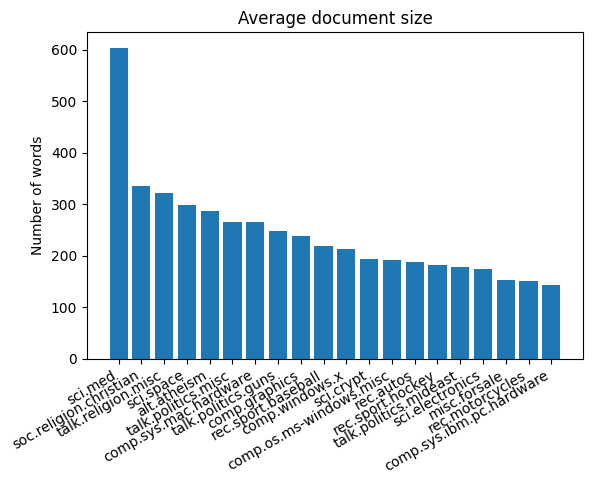

In [17]:
def graph_average_document_size(data, group_names, labels):
    groups = data.groupby(labels)
    average_length = groups.sum().sum(axis=1) / groups.size()
    average_length.index = group_names
    average_length.sort_values(inplace=True, ascending=False)

    fig, ax = plt.subplots()
    # slanted x-labels
    fig.autofmt_xdate()
    ax.bar(average_length.index, average_length)
    ax.set_title("Average document size")
    ax.set_ylabel("Number of words")

graph_average_document_size(DATA, GROUP_NAMES, LABELS)

The hypothesis seems to be born out.

Additionally, while Jaccard and cosine similarity have a range of $[0, 1]$, L2 similarity has a range of $[0, +\infty)$; the upper bound is determined only by the length of documents to be compared, meaning that without further normalization the metric is difficult to interpret.

Given the above points, I would grade the similarity metrics generally in the order cosine > Jaccard > L2. If the particular application were the identification of duplicate or largely copied documents (i.e. plagiarism), then I believe that the Jaccard metric might work best.

<div class="custom-assignment-text">

# Parts 2 and 3: A nearest-neighbor classification system
    
</div>

<div class="custom-assignment-text">

A “nearest-neighbor” classification system is conceptually extremely simple, and often is very effective. Given a large dataset of labeled examples, a nearest-neighbor classification system will predict a label for a new example, $x$, as follows: it will find the element of the labeled dataset that is closest to $x$—closest in whatever metric makes the most sense for that dataset—and then output the label of this closest point. \[As you can imagine, there are many natural extensions of this system—for example considering the labels of the $r > 1$ closest neighbors.]

From a computational standpoint, naively, finding the closest point to $x$ might be time consuming if the
labeled dataset is large, or the points are very high dimensional. In the next two parts, you will explore two
ways of speeding up this computation: dimension reduction, and via locality sensitive hashing.

</div>

<div class="custom-assignment-text">

## Part 2: Dimension Reduction
    
</div>

<div class="custom-assignment-text">

### Goal
The goal of this part is to get a feel for the trade-off in dimensionality reduction between the quality
of approximation and the number of dimensions used.
    
</div>

<div class="custom-assignment-text">

### Description

You may have noticed that it takes some time to compute all the distances in the previous part (though it should not take more than a minute or two). In this part we will implement a dimension reduction technique to reduce the running time, which can be used to also speed up classification.

In the following, $k$ will refer to the original dimension of your data, and $d$ will refer to the target dimension.

* Random Projection: Given a set of $k$-dimensional vectors $\{v1, v2, \dots\}$, define a $d × k$ matrix $M$ by drawing each entry randomly (and independently) from a normal distribution of mean 0 and variance 1. The $d$-dimensional reduced vector corresponding to $v_i$
is given by the matrix-vector product $Mv_i$.
We can think of the matrix $M$ as a set of $d$ random $k$-dimensional vectors $\{w1, \dots , wd\}$ (the rows
of $M$), and then the $j$th coordinate of the reduced vector $Mv_i$ is the inner product between that $v_i$ and $w_j$. If you need to review the basics of matrix-vector multiplication, see the primer on the course webpage.
    
</div>

<div class="custom-assignment-text">
    
(a) (3 points) (Baseline Classification) Implement the baseline cosine-similarity nearest-neighbor classification system that, for any given document, finds the document with largest cosine similarity, and
returns that newsgroup/label. (Do each computation using brute-force search.)
Compute the 20 × 20 matrix whose entry (A, B) is defined by the number of articles in group A that
have their nearest neighbor in group B.
Plot these results in a heatmap.
What is the average classification accuracy
    
</div>

In [18]:
# get all article similarities, minus the similarities to themselves
%time ALL_COSINE_SIMILARITIES = get_all_similarities(DATA, cosine_sim, include_diagonal=False)
assert ALL_COSINE_SIMILARITIES.shape == (1000, 1000)
ok()

CPU times: user 45.9 s, sys: 844 ms, total: 46.7 s
Wall time: 49.3 s


In [94]:
def get_most_similar_articles(similarity_matrix, labels):
    # get the most similar article ID for each article,
    most_similar_articles = pd.DataFrame(similarity_matrix.idxmax(), columns=["most_similar_id"])
    assert most_similar_articles.shape == (1000, 1)

    # then join with `label` to get the category ids
    most_similar_articles = most_similar_articles.join(labels, on="article_id")
    most_similar_articles.rename(columns={0: "article_category_id"}, inplace=True)
    most_similar_articles = most_similar_articles.join(labels, on="most_similar_id")
    most_similar_articles.rename(columns={0: "most_similar_article_category_id"}, inplace=True)
    return most_similar_articles

MOST_SIMILAR_ARTICLES_COSINE = get_most_similar_articles(ALL_COSINE_SIMILARITIES, LABELS)
assert MOST_SIMILAR_ARTICLES_COSINE.shape == (1000, 3)
ok()

In [100]:
def count_and_shape_nearest_neighbor_articles(most_similar_articles):
    """Count number of articles in each topic were the most similar, then
       format into a 2D dataframe with label strings for the index and columns"""
    
    counts = pd.DataFrame(most_similar_articles.groupby("article_category_id")["most_similar_article_category_id"].value_counts())
    
    counts = counts.unstack(fill_value=0)
    counts.columns = counts.columns.get_level_values(1).map(lambda idx: GROUP_NAMES[idx])
    counts = counts.rename(index=GROUP_NAMES, columns=GROUP_NAMES)
    return counts

def report_nearest_neighbor_accuracy(counts, title):
    bokeh_heat_map(counts, title)
    average_accuracy = (np.diag(counts) / counts.sum(axis=1)).mean()
    html(f"<b>Average classification accuracy was {average_accuracy:.3f}</b>")
    

_counts = count_and_shape_nearest_neighbor_articles(MOST_SIMILAR_ARTICLES_COSINE)
assert _counts.shape == (20, 20)
ok()

report_nearest_neighbor_accuracy(_counts, "Category of Most Similar Article")

<div class="custom-assignment-text">
    
(b) (2 points) Your plots for Part 1(b) were symmetric—why is the matrix in (a) not symmetric?
    
</div>

The plot should not be symmetric in this case because we are taking the maximum over all similarities to a document, which is not a symmetric relationship. For example, let's say there's a document A which is quite unique, with a maximum similarity of 0.001 to another document B. Document B may not necessarily be that unusual, and perhaps there are other documents for which it has a similarity of 0.8. 

<div class="custom-assignment-text">
    
(c) (7 points) Implement the random projection dimension reduction function and plot the nearest-neighbor
visualization as in part (a) for cosine similarity and d = 10, 25, 50, 100, 200, 500, 1000.
What is the average classification error for each of these settings?
For which values of the target dimension are the results comparable to the original dataset?

</div>

In [96]:
from numpy.random import default_rng
def get_random_matrix(d, k, rng: np.random.Generator=default_rng()):
    return rng.standard_normal(size=(d, k))

In [103]:
def lower_dimensional_nearest_neighbor_experiment(d: int):
    dk_matrix = get_random_matrix(d, DATA.shape[1])
    assert dk_matrix.shape == (d, DATA.shape[1])
    
    approximate_data = np.matmul(dk_matrix,  DATA.transpose()).transpose()
    assert approximate_data.shape == (DATA.shape[0], d)
    
    all_sims = get_all_similarities(approximate_data, cosine_sim, include_diagonal=False)
    assert all_sims.shape == (DATA.shape[0], DATA.shape[0])
    
    most_similar_articles = get_most_similar_articles(all_sims, LABELS)
    assert most_similar_articles.shape == (DATA.shape[0], 3)
    
    counts = count_and_shape_nearest_neighbor_articles(most_similar_articles)
    assert counts.shape == (20, 20)
    
    report_nearest_neighbor_accuracy(counts, f"Category of Most Similar Article (d={d})")

for d in [2000, 1000, 500, 200, 100, 50, 25, 10]:
    lower_dimensional_nearest_neighbor_experiment(d)

ok()

The performance when $d=\{2000, 1000, 500\}$ are all very similar and comparable to using the full data set; accuracy only drops by about 1%. The performance drops about 5% for $d=\{200, 100\}$, after which there's a sharp decline in accuracy.

<div class="custom-assignment-text">
    
(d) (5 points) Suppose you are trying to build a very fast article classification system, and have an enormous dataset of $n$ labeled tweets/articles. What is the time it takes to reduce the dimensionality of the data? Give the Big-Oh runtime as a function of $n$ (the number of labeled datapoints), $k$ (the original dimension of each datapoint), and $d$ (the reduced dimension). What is the overall Big-Oh runtime of classifying a new article? [Feel free to assume a naive matrix multiplication algorithm, as opposed to "fast matrix multiplication" algorithms, such as Strassen's algorithm.]
    
</div>

Reducing the dimensionality of the data is a matter of multiplying the $d{\text -}k$-dimensional matrix $M$ by the $k{\text -}n$ dimensional data matrix. This naive matrix multiplication runs in $O(knd)$ time.

Because dimensionality reduction on our dataset can be done once offline and the results re-used forever after, we can ignore this the dimensionality reduction run time when characterizing the run time for classification. Classification means finding the cosine similarity with all $n$ previously-classified articles, and the run time for cosine similarity is $O(d)$, so overall classification is $O(nd)$; reducing $d$ from 20,000 to 1,000 speeds up classification by roughly 20 times.

<div class="custom-assignment-text">
    
Now suppose you are instead trying to classify tweets; the bag-of-words representation is still a $k$-dimensional vector, but now each tweet has, say, only $50 \ll k$ words. Explain how you could exploit the
sparsity of the data to improve the runtime of the naive cosine-similarity nearest-neighbor classification system (from part (a)).

</div>

Since the documents are so short, one very simple thing that we can do is to only compare a new tweet with classified tweets that share at least one word in common. This would reduce the number of documents to calculate a cosine similarity with down to $k \ll 50$, so the overall run time would be $O(50|V|)$, where $|V|$ is the size of the vocabulary of all classified tweets. The $|V|$ component could, of course, also be reduced to $d \ll |V|$ as in (c), further reducing the run time. 

<div class="custom-assignment-text">

How does this runtime compare to that of a dimension-reduction nearest-neighbor system (as in the
first step of this part) that reduces the dimension to $d = 50$? [For this part, we expect a theoretical
analysis—you do not need to implement these algorithms and measure their runtimes empirically.]
    
</div>

Classification runs in $O(nd)$ time, so if one must choose only one of the above optimizations to implement, then it depends straightforwardly on whether $n$ or $|V|$ is bigger. Reducing the larger term to $50$ would be the better time savings.

<div class="custom-assignment-text">

## Part 3: Locality Sensitive Hashing
    
### Goal

The goal of this part is to implement a basic Locality-Sensitive-Hashing nearest-neighbor classification system, and experiment with the tradeoff between bucket size and number of hash tables. This part is largely an illustration that such techniques can be applied for fast classification—a larger dataset would have illustrated this better (though Parts 1 and 2 would have taken much longer :).

    
### Description

You will implement the Random Hyperplane Hashing LSH scheme, which has the property that vectors with larger cosine similarity will have a higher probability of colliding (i.e. hashing to the same value). [You will be able to reuse much of the code from Part 2.] The hashing scheme, and associated nearest-neighbor classification system, is defined as follows:

* Hyperplane Hashing: Construct $\ell$ hashtables in the following manner: for the $i$'th hashtable, define a $d × k$ matrix $Mi$ by drawing each entry randomly (and independently) from a normal distribution of mean 0 and variance 1. The $i$'th hashvalue of the $k$-dimensional vector $v$ is defined as the binary vector $sgn(Miv) ∈ {0, 1}^d$, where each positive coordinate of $Miv$ is replaced by a "1" and each nonpositive coordinate by a "0". Note that each hashtable has $2d$ buckets, and each data point is placed in exactly
one bucket of each of the $\ell$ hashtables.

* Classification: Suppose each original datapoint $v$ has already been hashed (to bucket $sgn(Miv)$ of the $i$th hashtable, for each $i$). Then, to predict the label of a (new) query vector $q$, do the following: (i) compute its $\ell$ hashvalues (bucket $sgn(Miu)$ of the $i$th hashtable); (ii) consider the set $Sq$ of the original datapoints that were placed in at least one of these $\ell$ buckets; (iii) among all points of $Sq$, compute the data point $x$ that is most similar to the query $q$ (using brute-force search over $Sq$); and (iv) label $q$ with $x$’s label.
    
</div>

<div class="custom-assignment-text">

(a) (3 points) Consider the $i$th hash tables in the above scheme, corresponding to matrix $Mi$. For two
vectors, $x, y ∈ Rk$ that form an angle of $angle(x, y) = θ < π/2$ radians (i.e. $x$ and $y$ form an acute angle of $θ$), what is the probability (over the randomness in the construction of the matrix $Mi$) that they hash to the same bucket in this $i$th hash function? \[Hint: for each of the $d$ coordinates that define the hash of $x$ and $y$, what is the probability that they are equal, as a function of $θ$? To figure this out, it might be helpful to consider, geometrically, what it means for $x$ and $y$ to have the same sign when multiplied by a random vector. What does this look like in two dimensions? What random vectors will cause the inner products to have opposite signs?] Prove your claim in at most two sentences.

</div>